<a href="https://colab.research.google.com/github/sermelo/CNN_LSTM_stock_predictions/blob/main/Stock_market_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Agregar día de la semana y día del año

Crear un metodo con una clase que:
Devuleva si el día es trading o no.
Dada una fecha y hora, devolver el último día de trading 
* antes de las 13:30 UTC día anterior, despues día siguiente
* Después de las 20:00 para el día siguiente
* Entre horas eliminar, puesto que ya habrán afectado a la cotización

In [1]:
from google.colab import drive
import tarfile
from shutil import copyfile, move, copytree
import os

DATA_DIR = 'stock_data'
if not os.path.isdir(DATA_DIR):
    drive.mount('/gdrive')
    org_drive_files = '/gdrive/My Drive/Master Big Data/TFM2/stock_data/'
    copytree(org_drive_files, DATA_DIR)

Mounted at /gdrive


In [2]:
!ls stock_data

aapl.csv       csco.csv       hon.csv	     mcd.csv	    trv.csv
aapl_news.csv  csco_news.csv  hon_news.csv   mcd_news.csv   trv_news.csv
amgn.csv       cvx.csv	      ibm.csv	     mmm.csv	    unh.csv
amgn_news.csv  cvx_news.csv   ibm_news.csv   mmm_news.csv   unh_news.csv
axp.csv        dis.csv	      intc.csv	     mrk.csv	    v.csv
axp_news.csv   dis_news.csv   intc_news.csv  mrk_news.csv   v_news.csv
ba.csv	       dow.csv	      jnj.csv	     msft.csv	    vz.csv
ba_news.csv    dow_news.csv   jnj_news.csv   msft_news.csv  vz_news.csv
cat.csv        gs.csv	      jpm.csv	     nke.csv	    wba.csv
cat_news.csv   gs_news.csv    jpm_news.csv   nke_news.csv   wba_news.csv
crm.csv        hd.csv	      ko.csv	     pg.csv	    wmt.csv
crm_news.csv   hd_news.csv    ko_news.csv    pg_news.csv    wmt_news.csv


In [3]:
import os
import random
from math import sqrt
from datetime import datetime

import pytz

import matplotlib.pyplot as plt
from IPython.display import display, HTML

import pandas as pd
import numpy as np
import statistics 
import math

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from keras import Input, Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, BatchNormalization, Conv1D, Conv2D, MaxPooling1D, AveragePooling1D, MaxPooling2D, Flatten, Multiply, LeakyReLU, ReLU
from keras.callbacks import EarlyStopping,ModelCheckpoint

In [4]:
DJI_INDEX = ['mmm', 'axp', 'amgn', 'aapl', 'ba', 'cat', 'cvx', 'csco', 'ko', 'dow', 'gs', 'hd', 'hon', 'ibm', 'intc', 'jnj', 'jpm', 'mcd', 'mrk', 'msft', 'nke', 'pg', 'crm', 'trv', 'unh', 'vz', 'v', 'wba', 'wmt', 'dis']
SYMBOLS = DJI_INDEX

#FIRST_DATE = pd.Timestamp('2015-01-02') # Monday
#FIRST_DATE = pd.Timestamp('2014-01-02') # Monday
#LAST_DATE = pd.Timestamp('2019-12-31') # Friday
FIRST_DATE = pd.Timestamp('2014-01-02', tz=pytz.utc) # Monday
LAST_DATE = pd.Timestamp('2019-12-31', tz=pytz.utc) # Friday

print(f'Number of companies: {len(DJI_INDEX)}')

Number of companies: 30


In [5]:
def company_to_file(company):
    file_name = f'{company}.csv'
    if not (os.path.isfile(f'{DATA_DIR}/{file_name}')):
        raise ValueError(f'File {file_name} not found')
    return file_name

def company_to_news_file(company):
    file_name = f'{company}_news.csv'
    if not (os.path.isfile(f'{DATA_DIR}/{file_name}')):
        raise ValueError(f'File {file_name} not found')
    return file_name

def date_utc(s):
    return parse(s, tzinfos=tzutc)

def get_df(file_path):
    data = pd.read_csv(file_path, parse_dates=['Date'])
    #data = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    data = data.drop(['Adj Close'], axis=1)
    #data["Rel_Open"] = ((data["Open"] - data["Close"].shift(1))/ data["Close"].shift(1)) * 100
    #data["Rel_High"] = ((data["High"] - data["Close"].shift(1))/ data["Close"].shift(1)) * 100
    #data["Rel_Low"] = ((data["Low"] - data["Close"].shift(1))/ data["Close"].shift(1)) * 100

    data["Rel_Close"] = (data["Close"].diff(1) / data["Close"].shift(1)) * 100
    data["One_day_Y"] = (-data["Close"].diff(-1) / data["Close"]) * 100
    data["month_Y"] = (-data["Close"].diff(-21) / data["Close"]) * 100
    data["6_months_Y"] = (-data["Close"].diff(-126) / data["Close"]) * 100
    data["year_Y"] = (-data["Close"].diff(-252) / data["Close"]) * 100
    #(data["Close"].shift(-1))
    #data = data.iloc[1:] # First row doesn't contain percentage
    #print(data)
    data['Date'] = data['Date'].dt.tz_localize(pytz.utc)
    data = data[data['Date'] >= FIRST_DATE]
    data = data[data['Date'] <= LAST_DATE]
    #data = data.drop(['Close'], axis=1)
    #print(data)
    #print(data.iloc[0]['Date'])
    #print(data.iloc[-1]['Date'])
    return data
    
def get_data_dict():
    data_dict = {}
    for symbol in SYMBOLS:
        file_name = company_to_file(symbol)
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f'File {file_name} skipped because it doesn\'t exist')
        elif os.stat(file_path).st_size == 0:
            print(f'File {file_name} skipped because it is empty')
        else:
            #print(f'File {file_name}')
            data = get_df(file_path)
            if data.iloc[0]['Date'] != FIRST_DATE:
                print(f'File {file_name} doesn\'t have enough data({data.shape[0]}). It starts on {data.iloc[0]["Date"]} and should start on {FIRST_DATE}')
            elif data.iloc[-1]['Date'] != LAST_DATE:
                print(f'File {file_name} doesn\'t have data until {LAST_DATE.date()}')            
            else:
                print(f'File {file_name} added. Contains {data.shape[0]} rows')
                data_dict[symbol] = data
            #display(data_dict[symbol])
        #break
    return data_dict

def get_max(stocks, column):
    max = 0
    for symbol in stocks.keys():
        stock_max = stocks[symbol][column].max()
        if stock_max > max:
            max = stock_max
    return max

def get_min(stocks, column):
    min = 0
    for symbol in stocks.keys():
        stock_min = stocks[symbol][column].min()
        if stock_min < min:
            min = stock_min
    return min

#def normalize(stocks, column):
#    max_value = get_max(stocks, column)
#    min_value = get_min(stocks, column)
#    print(f'Normalizing {column}')
#    print(f'Max relative change: {max_value}')
#    print(f'Min relative change: {min_value}')
#    divisor = max(max_value, -min_value)
#    print(f'Divisor: {divisor}')
#    for symbol in stocks.keys():
#        stocks[symbol][column] = stocks[symbol][column]/divisor

def normalize(stock, column):
    max_value = stock[column].max()
    min_value = stock[column].min()
    divisor = max(max_value, -min_value)
    stock[column] = stock[column]/divisor
    return divisor

def normalize_all(stocks, normalization_values, column):
    for symbol in stocks.keys():
        divisor = normalize(stocks[symbol], column)
        if symbol not in normalization_values:
            normalization_values[symbol] = {}
        normalization_values[symbol][column] = divisor
    
stocks_data = get_data_dict()
print(f'Number of companies loaded: {len(stocks_data)}')
display(stocks_data['aapl'])



File mmm.csv added. Contains 1510 rows
File axp.csv added. Contains 1510 rows
File amgn.csv added. Contains 1510 rows
File aapl.csv added. Contains 1510 rows
File ba.csv added. Contains 1510 rows
File cat.csv added. Contains 1510 rows
File cvx.csv added. Contains 1510 rows
File csco.csv added. Contains 1510 rows
File ko.csv added. Contains 1510 rows
File dow.csv doesn't have enough data(199). It starts on 2019-03-20 00:00:00+00:00 and should start on 2014-01-02 00:00:00+00:00
File gs.csv added. Contains 1510 rows
File hd.csv added. Contains 1510 rows
File hon.csv added. Contains 1510 rows
File ibm.csv added. Contains 1510 rows
File intc.csv added. Contains 1510 rows
File jnj.csv added. Contains 1510 rows
File jpm.csv added. Contains 1510 rows
File mcd.csv added. Contains 1510 rows
File mrk.csv added. Contains 1510 rows
File msft.csv added. Contains 1510 rows
File nke.csv added. Contains 1510 rows
File pg.csv added. Contains 1510 rows
File crm.csv added. Contains 1510 rows
File trv.csv 

,Date,Open,High,Low,Close,Volume,Rel_Close,One_day_Y,month_Y,6_months_Y,year_Y
21,2014-01-02 00:00:00+00:00,19.845715,19.893929,19.715000,19.754642,234684800,-1.406368,-2.196582,-9.328729,18.997348,38.359885
22,2014-01-03 00:00:00+00:00,19.745001,19.775000,19.301071,19.320715,392467600,-2.196582,0.545301,-5.950313,24.180187,37.481972
23,2014-01-06 00:00:00+00:00,19.194643,19.528572,19.057142,19.426071,412610800,0.545301,-0.715157,-5.761767,22.708807,36.749222
24,2014-01-07 00:00:00+00:00,19.440001,19.498571,19.211428,19.287144,317209200,-0.715157,0.633282,-5.097779,23.644538,39.665572
25,2014-01-08 00:00:00+00:00,19.243214,19.484285,19.238928,19.409286,258529600,0.633282,-1.277007,-4.375674,22.415631,44.119160
...,...,...,...,...,...,...,...,...,...,...,...
1526,2019-12-24 00:00:00+00:00,71.172501,71.222504,70.730003,71.067497,48478800,0.095066,1.984035,8.681896,28.342777,NaN
1527,2019-12-26 00:00:00+00:00,71.205002,72.495003,71.175003,72.477501,93121200,1.984035,-0.037948,9.582284,21.979235,NaN
1528,2019-12-27 00:00:00+00:00,72.779999,73.492500,72.029999,72.449997,146266000,-0.037948,0.593513,11.918568,24.837824,NaN
1529,2019-12-30 00:00:00+00:00,72.364998,73.172501,71.305000,72.879997,144114400,0.593513,0.730655,11.097012,25.137213,NaN


In [6]:
def print_stats(company, column_name):
    print(f'Data about {company} for column {column_name}')
    stock = stocks_data[company]
    print(f'Mean: {stock[column_name].mean()}')
    #print(f'Mode: {stock[column_name].mode()[0]}')
    print(f'Median: {stock[column_name].median()}')
    print(f'Var: {stock[column_name].var()}')
    print(f'Max: {stock[column_name].max()}')
    print(f'Min: {stock[column_name].min()}')

company_name = 'aapl'
print_stats(company_name, 'One_day_Y')
print_stats(company_name, 'month_Y')
print_stats(company_name, '6_months_Y')
print_stats(company_name, 'year_Y')

Data about aapl for column One_day_Y
Mean: 0.1002573123323623
Median: 0.089207636271058
Var: 2.354644704773894
Max: 8.198186315062452
Min: -9.960737082066853
Data about aapl for column month_Y
Mean: 2.232726148631419
Median: 2.6350746094371686
Var: 52.43424195386809
Max: 21.445423962465295
Min: -20.63035820285293
Data about aapl for column 6_months_Y
Mean: 13.091567083642948
Median: 15.294059789418867
Var: 319.8476265016759
Max: 64.91673455915455
Min: -26.811540739817325
Data about aapl for column year_Y
Mean: 29.51314590290402
Median: 27.338039838713335
Var: 1194.6635105325008
Max: 160.92366671703775
Min: -29.802249858154322


In [7]:
def company_to_file(company):
    file_name = f'{company}.csv'
    if not (os.path.isfile(f'{DATA_DIR}/{file_name}')):
        raise ValueError(f'File {file_name} not found')
    return file_name

def company_to_news_file(company):
    file_name = f'{company}_news.csv'
    if not (os.path.isfile(f'{DATA_DIR}/{file_name}')):
        raise ValueError(f'File {file_name} not found')
    return file_name

def date_utc(s):
    return parse(s, tzinfos=tzutc)

def get_df(file_path):
    data = pd.read_csv(file_path, parse_dates=['Date'])
    #data = data.drop(['Open', 'High', 'Low', 'Adj Close', 'Volume'], axis=1)
    data = data.drop(['Adj Close'], axis=1)
    #data["Rel_Open"] = ((data["Open"] - data["Close"].shift(1))/ data["Close"].shift(1)) * 100
    #data["Rel_High"] = ((data["High"] - data["Close"].shift(1))/ data["Close"].shift(1)) * 100
    #data["Rel_Low"] = ((data["Low"] - data["Close"].shift(1))/ data["Close"].shift(1)) * 100

    data["Rel_Close"] = (data["Close"].diff(1) / data["Close"].shift(1)) * 100
    data["One_day_Y"] = (-data["Close"].diff(-1) / data["Close"]) * 100
    data["month_Y"] = (-data["Close"].diff(-21) / data["Close"]) * 100
    data["6_months_Y"] = (-data["Close"].diff(-126) / data["Close"]) * 100
    data["year_Y"] = (-data["Close"].diff(-252) / data["Close"]) * 100
    #(data["Close"].shift(-1))
    #data = data.iloc[1:] # First row doesn't contain percentage
    #print(data)
    data['Date'] = data['Date'].dt.tz_localize(pytz.utc)
    data = data[data['Date'] >= FIRST_DATE]
    data = data[data['Date'] <= LAST_DATE]
    data = data.drop(['Close'], axis=1)
    #print(data)
    #print(data.iloc[0]['Date'])
    #print(data.iloc[-1]['Date'])
    return data
    
def get_data_dict():
    data_dict = {}
    for symbol in SYMBOLS:
        file_name = company_to_file(symbol)
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f'File {file_name} skipped because it doesn\'t exist')
        elif os.stat(file_path).st_size == 0:
            print(f'File {file_name} skipped because it is empty')
        else:
            #print(f'File {file_name}')
            data = get_df(file_path)
            if data.iloc[0]['Date'] != FIRST_DATE:
                print(f'File {file_name} doesn\'t have enough data({data.shape[0]}). It starts on {data.iloc[0]["Date"]} and should start on {FIRST_DATE}')
            elif data.iloc[-1]['Date'] != LAST_DATE:
                print(f'File {file_name} doesn\'t have data until {LAST_DATE.date()}')            
            else:
                print(f'File {file_name} added. Contains {data.shape[0]} rows')
                data_dict[symbol] = data
            #display(data_dict[symbol])
        #break
    return data_dict

def get_max(stocks, column):
    max = 0
    for symbol in stocks.keys():
        stock_max = stocks[symbol][column].max()
        if stock_max > max:
            max = stock_max
    return max

def get_min(stocks, column):
    min = 0
    for symbol in stocks.keys():
        stock_min = stocks[symbol][column].min()
        if stock_min < min:
            min = stock_min
    return min

#def normalize(stocks, column):
#    max_value = get_max(stocks, column)
#    min_value = get_min(stocks, column)
#    print(f'Normalizing {column}')
#    print(f'Max relative change: {max_value}')
#    print(f'Min relative change: {min_value}')
#    divisor = max(max_value, -min_value)
#    print(f'Divisor: {divisor}')
#    for symbol in stocks.keys():
#        stocks[symbol][column] = stocks[symbol][column]/divisor

def normalize(stock, column):
    max_value = stock[column].max()
    min_value = stock[column].min()
    divisor = max(max_value, -min_value)
    stock[column] = stock[column]/divisor
    return divisor

def normalize_all(stocks, normalization_values, column):
    for symbol in stocks.keys():
        divisor = normalize(stocks[symbol], column)
        if symbol not in normalization_values:
            normalization_values[symbol] = {}
        normalization_values[symbol][column] = divisor
    
stocks_data = get_data_dict()
print(f'Number of companies loaded: {len(stocks_data)}')
display(stocks_data['aapl'])

normalization_values = {}
print(stocks_data.keys())
normalize_all(stocks_data, normalization_values, "One_day_Y")
normalize_all(stocks_data, normalization_values, "month_Y")
normalize_all(stocks_data, normalization_values, "6_months_Y")
normalize_all(stocks_data, normalization_values, "year_Y")

display(stocks_data['aapl'])


File mmm.csv added. Contains 1510 rows
File axp.csv added. Contains 1510 rows
File amgn.csv added. Contains 1510 rows
File aapl.csv added. Contains 1510 rows
File ba.csv added. Contains 1510 rows
File cat.csv added. Contains 1510 rows
File cvx.csv added. Contains 1510 rows
File csco.csv added. Contains 1510 rows
File ko.csv added. Contains 1510 rows
File dow.csv doesn't have enough data(199). It starts on 2019-03-20 00:00:00+00:00 and should start on 2014-01-02 00:00:00+00:00
File gs.csv added. Contains 1510 rows
File hd.csv added. Contains 1510 rows
File hon.csv added. Contains 1510 rows
File ibm.csv added. Contains 1510 rows
File intc.csv added. Contains 1510 rows
File jnj.csv added. Contains 1510 rows
File jpm.csv added. Contains 1510 rows
File mcd.csv added. Contains 1510 rows
File mrk.csv added. Contains 1510 rows
File msft.csv added. Contains 1510 rows
File nke.csv added. Contains 1510 rows
File pg.csv added. Contains 1510 rows
File crm.csv added. Contains 1510 rows
File trv.csv 

,Date,Open,High,Low,Volume,Rel_Close,One_day_Y,month_Y,6_months_Y,year_Y
21,2014-01-02 00:00:00+00:00,19.845715,19.893929,19.715000,234684800,-1.406368,-2.196582,-9.328729,18.997348,38.359885
22,2014-01-03 00:00:00+00:00,19.745001,19.775000,19.301071,392467600,-2.196582,0.545301,-5.950313,24.180187,37.481972
23,2014-01-06 00:00:00+00:00,19.194643,19.528572,19.057142,412610800,0.545301,-0.715157,-5.761767,22.708807,36.749222
24,2014-01-07 00:00:00+00:00,19.440001,19.498571,19.211428,317209200,-0.715157,0.633282,-5.097779,23.644538,39.665572
25,2014-01-08 00:00:00+00:00,19.243214,19.484285,19.238928,258529600,0.633282,-1.277007,-4.375674,22.415631,44.119160
...,...,...,...,...,...,...,...,...,...,...
1526,2019-12-24 00:00:00+00:00,71.172501,71.222504,70.730003,48478800,0.095066,1.984035,8.681896,28.342777,NaN
1527,2019-12-26 00:00:00+00:00,71.205002,72.495003,71.175003,93121200,1.984035,-0.037948,9.582284,21.979235,NaN
1528,2019-12-27 00:00:00+00:00,72.779999,73.492500,72.029999,146266000,-0.037948,0.593513,11.918568,24.837824,NaN
1529,2019-12-30 00:00:00+00:00,72.364998,73.172501,71.305000,144114400,0.593513,0.730655,11.097012,25.137213,NaN


dict_keys(['mmm', 'axp', 'amgn', 'aapl', 'ba', 'cat', 'cvx', 'csco', 'ko', 'gs', 'hd', 'hon', 'ibm', 'intc', 'jnj', 'jpm', 'mcd', 'mrk', 'msft', 'nke', 'pg', 'crm', 'trv', 'unh', 'vz', 'v', 'wba', 'wmt', 'dis'])


,Date,Open,High,Low,Volume,Rel_Close,One_day_Y,month_Y,6_months_Y,year_Y
21,2014-01-02 00:00:00+00:00,19.845715,19.893929,19.715000,234684800,-1.406368,-0.220524,-0.434999,0.292642,0.238373
22,2014-01-03 00:00:00+00:00,19.745001,19.775000,19.301071,392467600,-2.196582,0.054745,-0.277463,0.372480,0.232918
23,2014-01-06 00:00:00+00:00,19.194643,19.528572,19.057142,412610800,0.545301,-0.071798,-0.268671,0.349814,0.228364
24,2014-01-07 00:00:00+00:00,19.440001,19.498571,19.211428,317209200,-0.715157,0.063578,-0.237709,0.364229,0.246487
25,2014-01-08 00:00:00+00:00,19.243214,19.484285,19.238928,258529600,0.633282,-0.128204,-0.204038,0.345298,0.274162
...,...,...,...,...,...,...,...,...,...,...
1526,2019-12-24 00:00:00+00:00,71.172501,71.222504,70.730003,48478800,0.095066,0.199186,0.404837,0.436602,NaN
1527,2019-12-26 00:00:00+00:00,71.205002,72.495003,71.175003,93121200,1.984035,-0.003810,0.446822,0.338576,NaN
1528,2019-12-27 00:00:00+00:00,72.779999,73.492500,72.029999,146266000,-0.037948,0.059585,0.555763,0.382611,NaN
1529,2019-12-30 00:00:00+00:00,72.364998,73.172501,71.305000,144114400,0.593513,0.073353,0.517454,0.387222,NaN


In [8]:
def company_to_news_file(company):
    file_name = f'{company}_news.csv'
    if not (os.path.isfile(f'{DATA_DIR}/{file_name}')):
        raise ValueError(f'File {file_name} not found')
    return file_name

def get_news_df(file_path):
    data = pd.read_csv(file_path, parse_dates=['date'])
    data = data.sort_values(by=['date'])
    data = data[data['date'] >= FIRST_DATE]
    data = data[data['date'] <= LAST_DATE + pd.DateOffset(1)]
    return data

def get_news_data_dict():
    data_dict = {}
    for symbol in SYMBOLS:
        file_name = company_to_news_file(symbol)
        file_path = os.path.join(DATA_DIR, file_name)
        if not os.path.exists(file_path):
            print(f'File {file_name} skipped because it doesn\'t exist')
        elif os.stat(file_path).st_size == 0:
            print(f'File {file_name} skipped because it is empty')
        else:
            print(f'File {file_name}')
            data = get_news_df(file_path)
            #display(data)

            if data.iloc[0]["date"].date() != FIRST_DATE.date():
                print(f'File {file_name} doesn\'t have enough data({data.shape[0]}). It starts on {data.iloc[0]["date"].date()} and should start on {FIRST_DATE.date()}')
            elif data.iloc[-1]['date'].date() != LAST_DATE.date():
                print(f'File {file_name} doesn\'t have data until {LAST_DATE.date()}')           
            else:
                print(f'File {file_name} added. Contains {data.shape[0]} rows')
                data_dict[symbol] = data
            
        #break
    return data_dict

#NEWS_DATA_DICT = get_news_data_dict()
#print(f'Number of companies loaded: {len(NEWS_DATA_DICT)}')
#display(NEWS_DATA_DICT['aapl'])

#print(NEWS_DATA_DICT.keys())

In [9]:
def plot_stock(column, names, dfs):
    plt.figure(figsize=(40, 300))
    plt.subplots_adjust(top=1.25, bottom=1.2)
    
    for i, company in enumerate(dfs, 1):
        plt.subplot(2, 2, i)
        plt.plot(company['Date'], company[column])
        #company[column].plot()
        plt.ylabel('Precio')
        plt.xlabel('Fecha')
        plt.title(f'Precio de las acciones de {names[i-1]}')

def bars_stock(column, names, dfs):
    plt.figure(figsize=(40, 300))
    plt.subplots_adjust(top=1.25, bottom=1.2)
    months = np.random.randint(1, 13, size=30)
    for i, company in enumerate(dfs, 1):
        plt.subplot(2, 2, i)
        plt.hist(company[column], bins = 50)
        #company[column].plot()
        plt.ylabel('Frecuencía')
        plt.xlabel('Precio de las acciones')
        plt.title(f'Frecuencía del precio de las acciones de {names[i-1]}')
        #plt.ylabel(column)
        #plt.xlabel(None)
        #plt.title(names[i-1])

names_list= []
dfs_list = []
i = 0
for key in stocks_data.keys():
    i += 1
    names_list.append(key)
    dfs_list.append(stocks_data[key])
    if i == 4:
        break
#plot_stock('Close', names_list, dfs_list)


In [10]:
#bars_stock('Close', names_list, dfs_list)



In [11]:
#plot_stock('Close', names_list, dfs_list)

In [12]:
#bars_stock('Close', names_list, dfs_list)

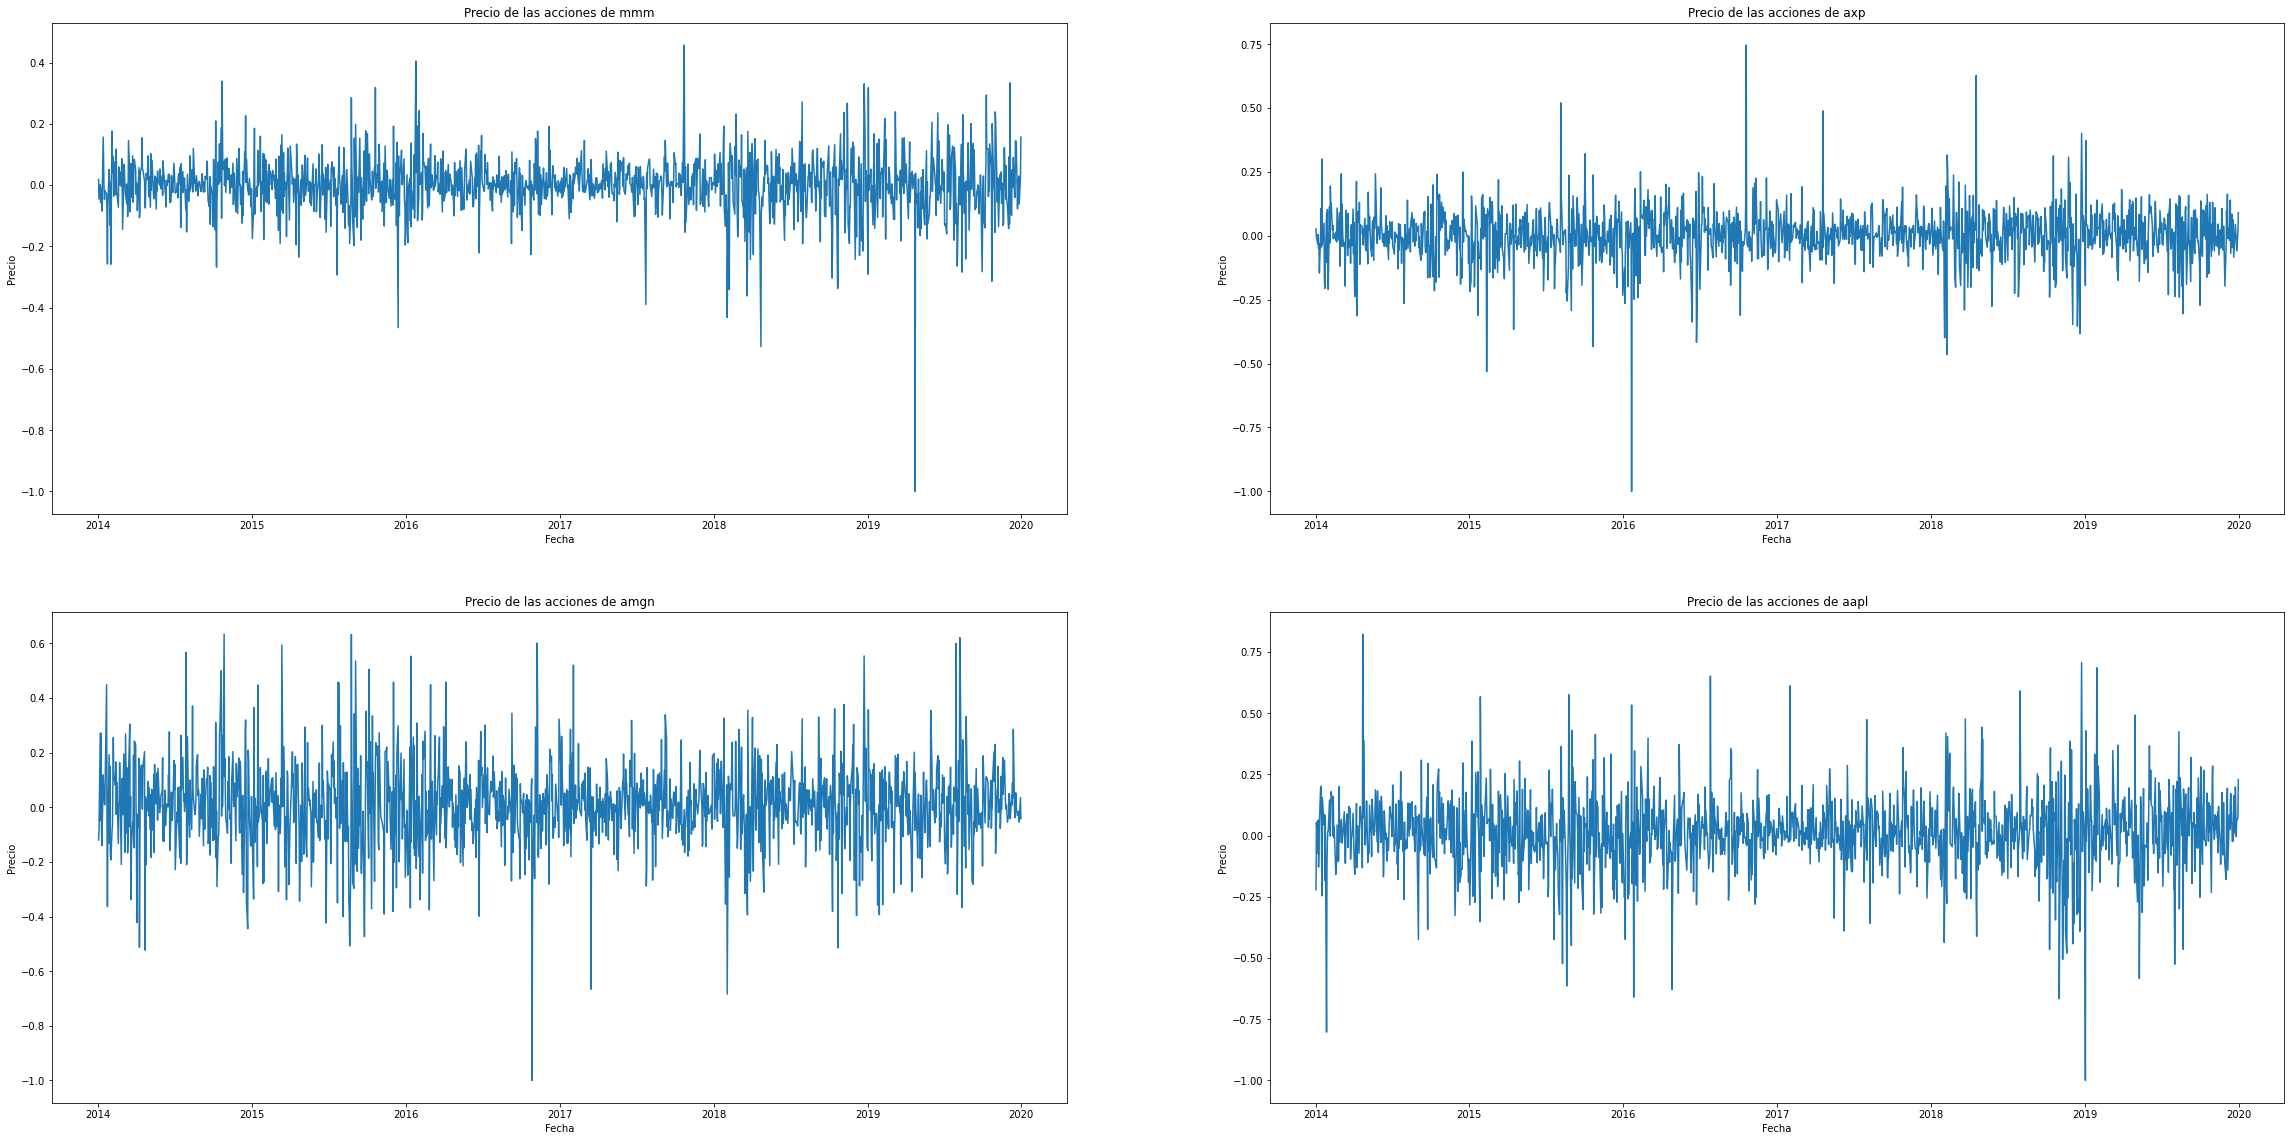

In [13]:
plot_stock('One_day_Y', names_list, dfs_list)

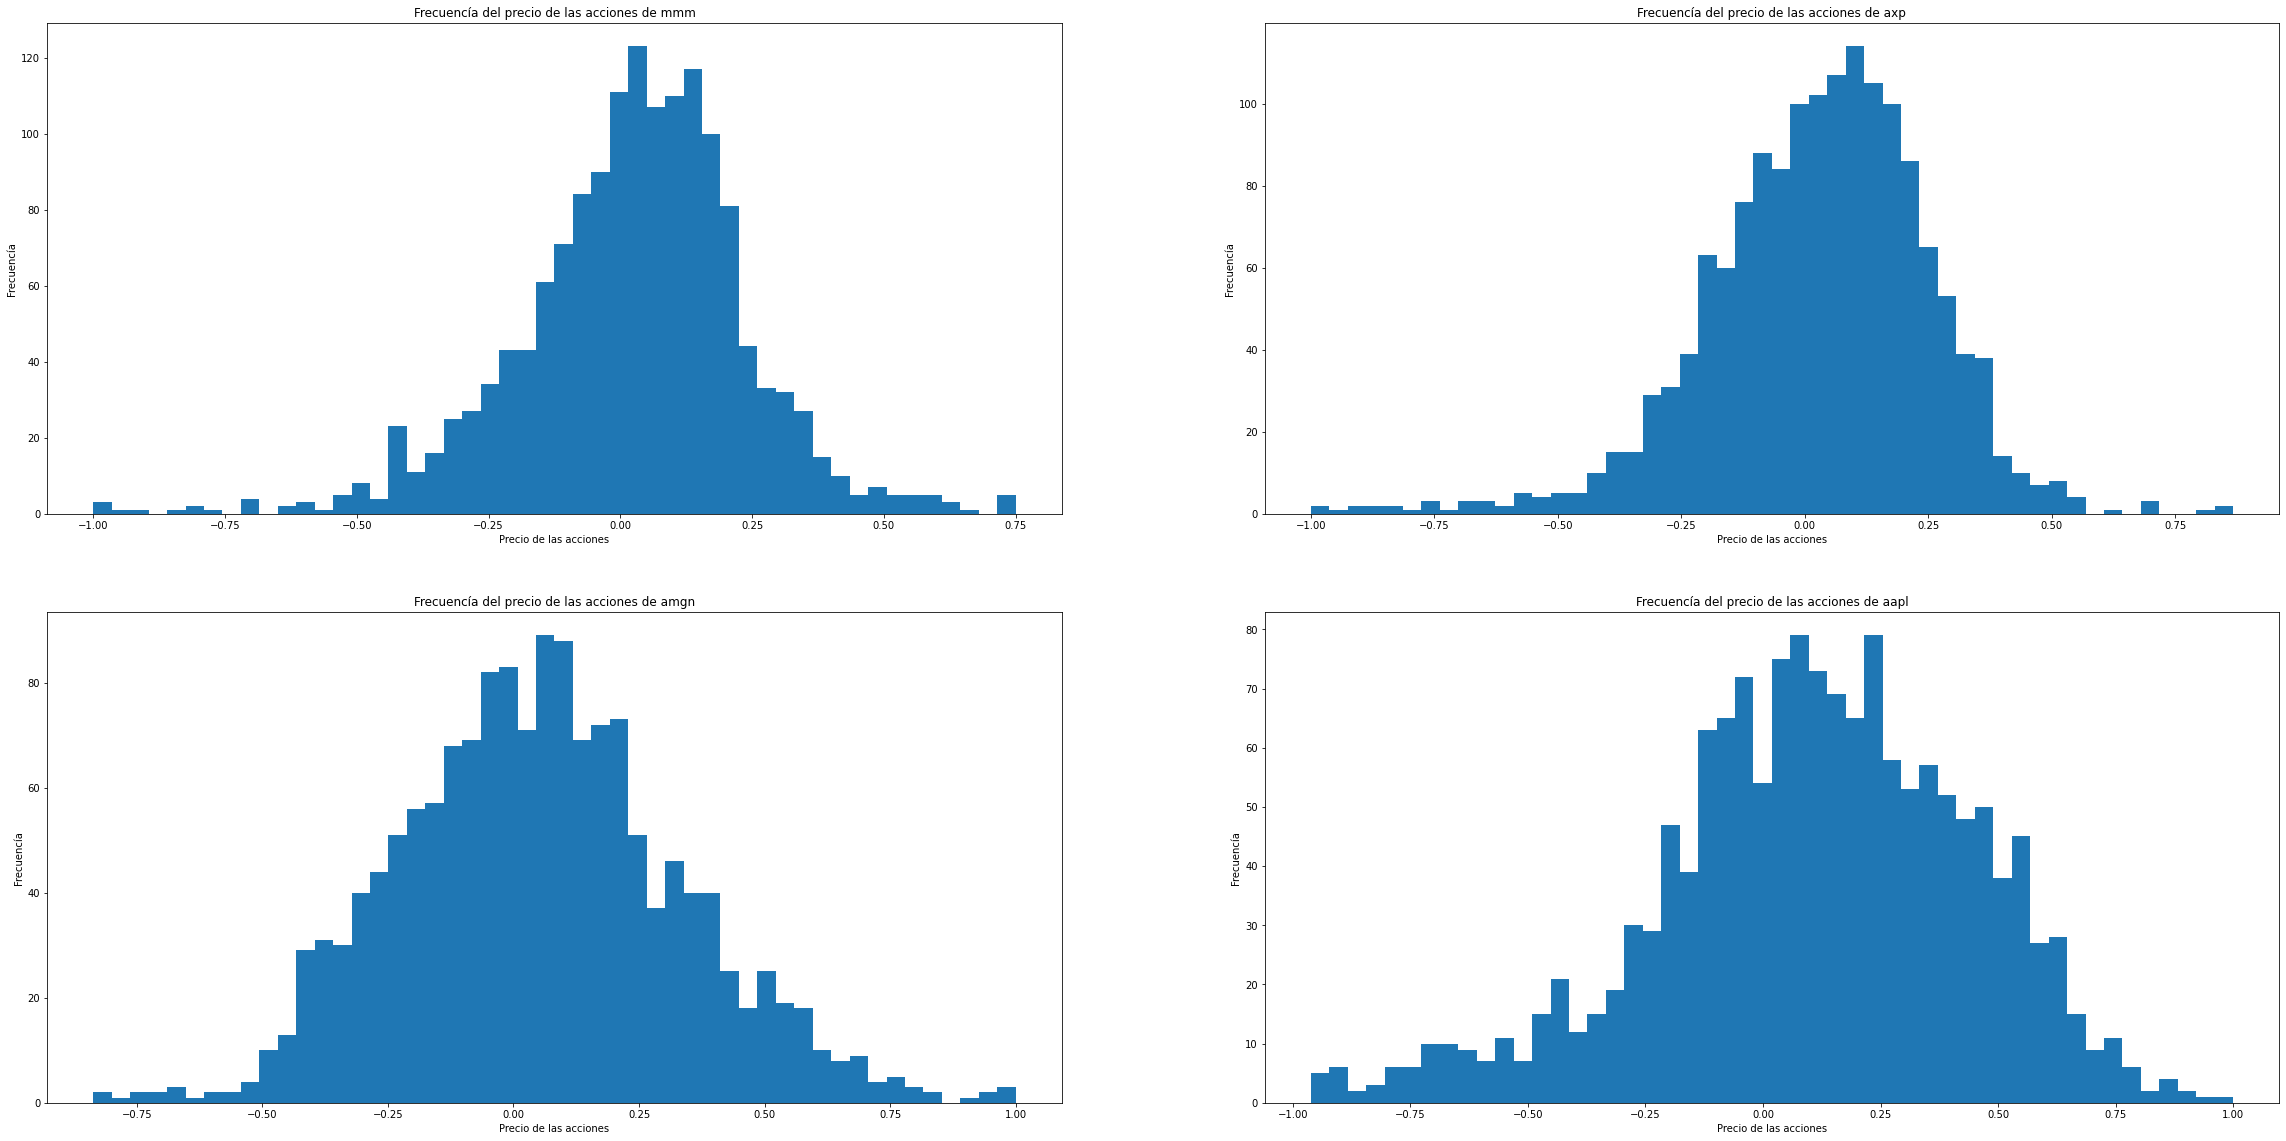

In [14]:
bars_stock('month_Y', names_list, dfs_list)

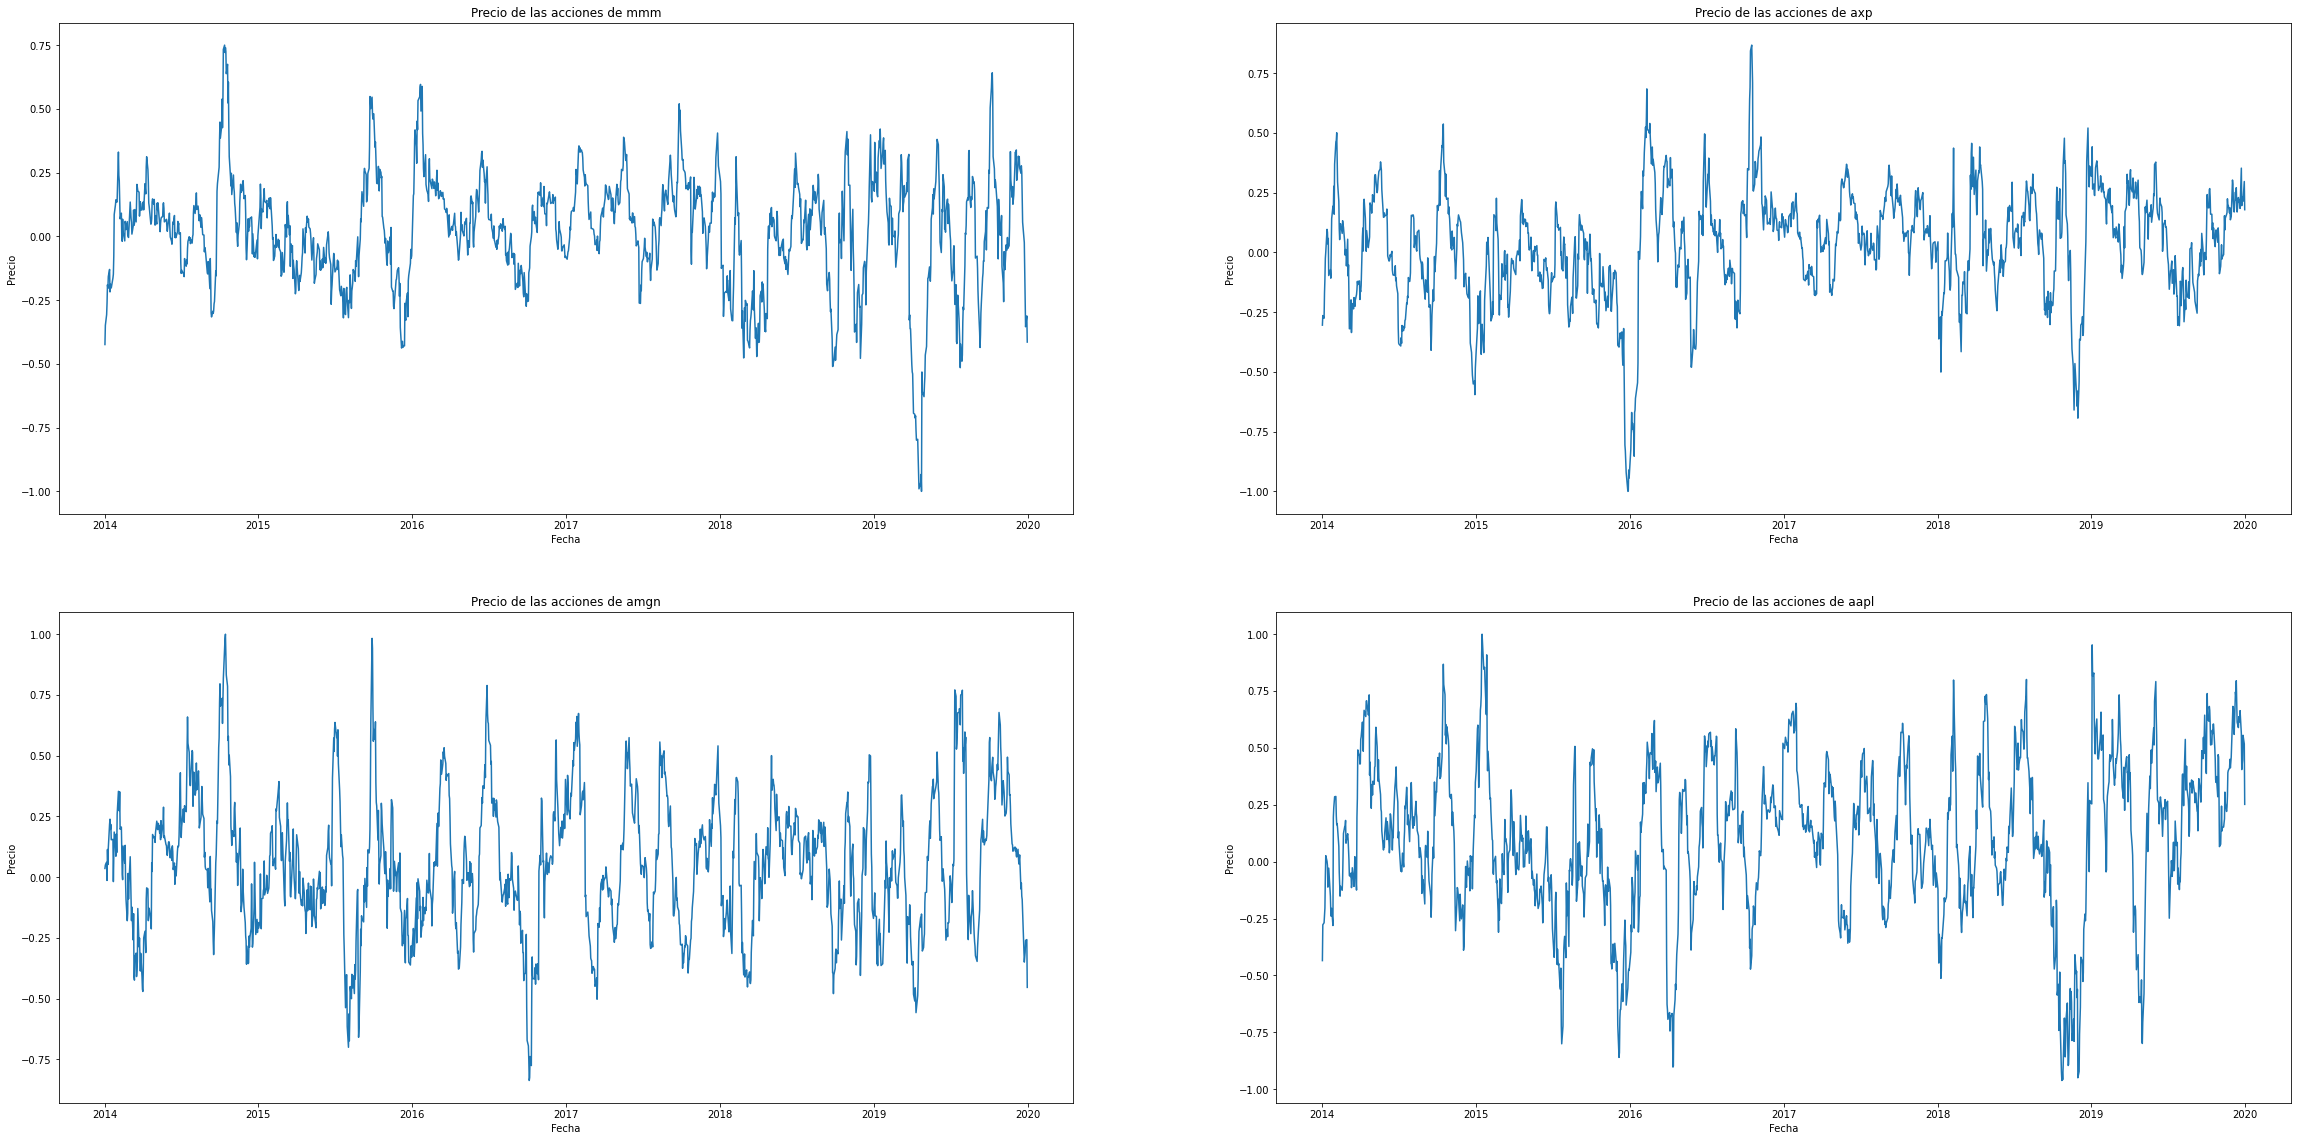

In [15]:
plot_stock('month_Y', names_list, dfs_list)

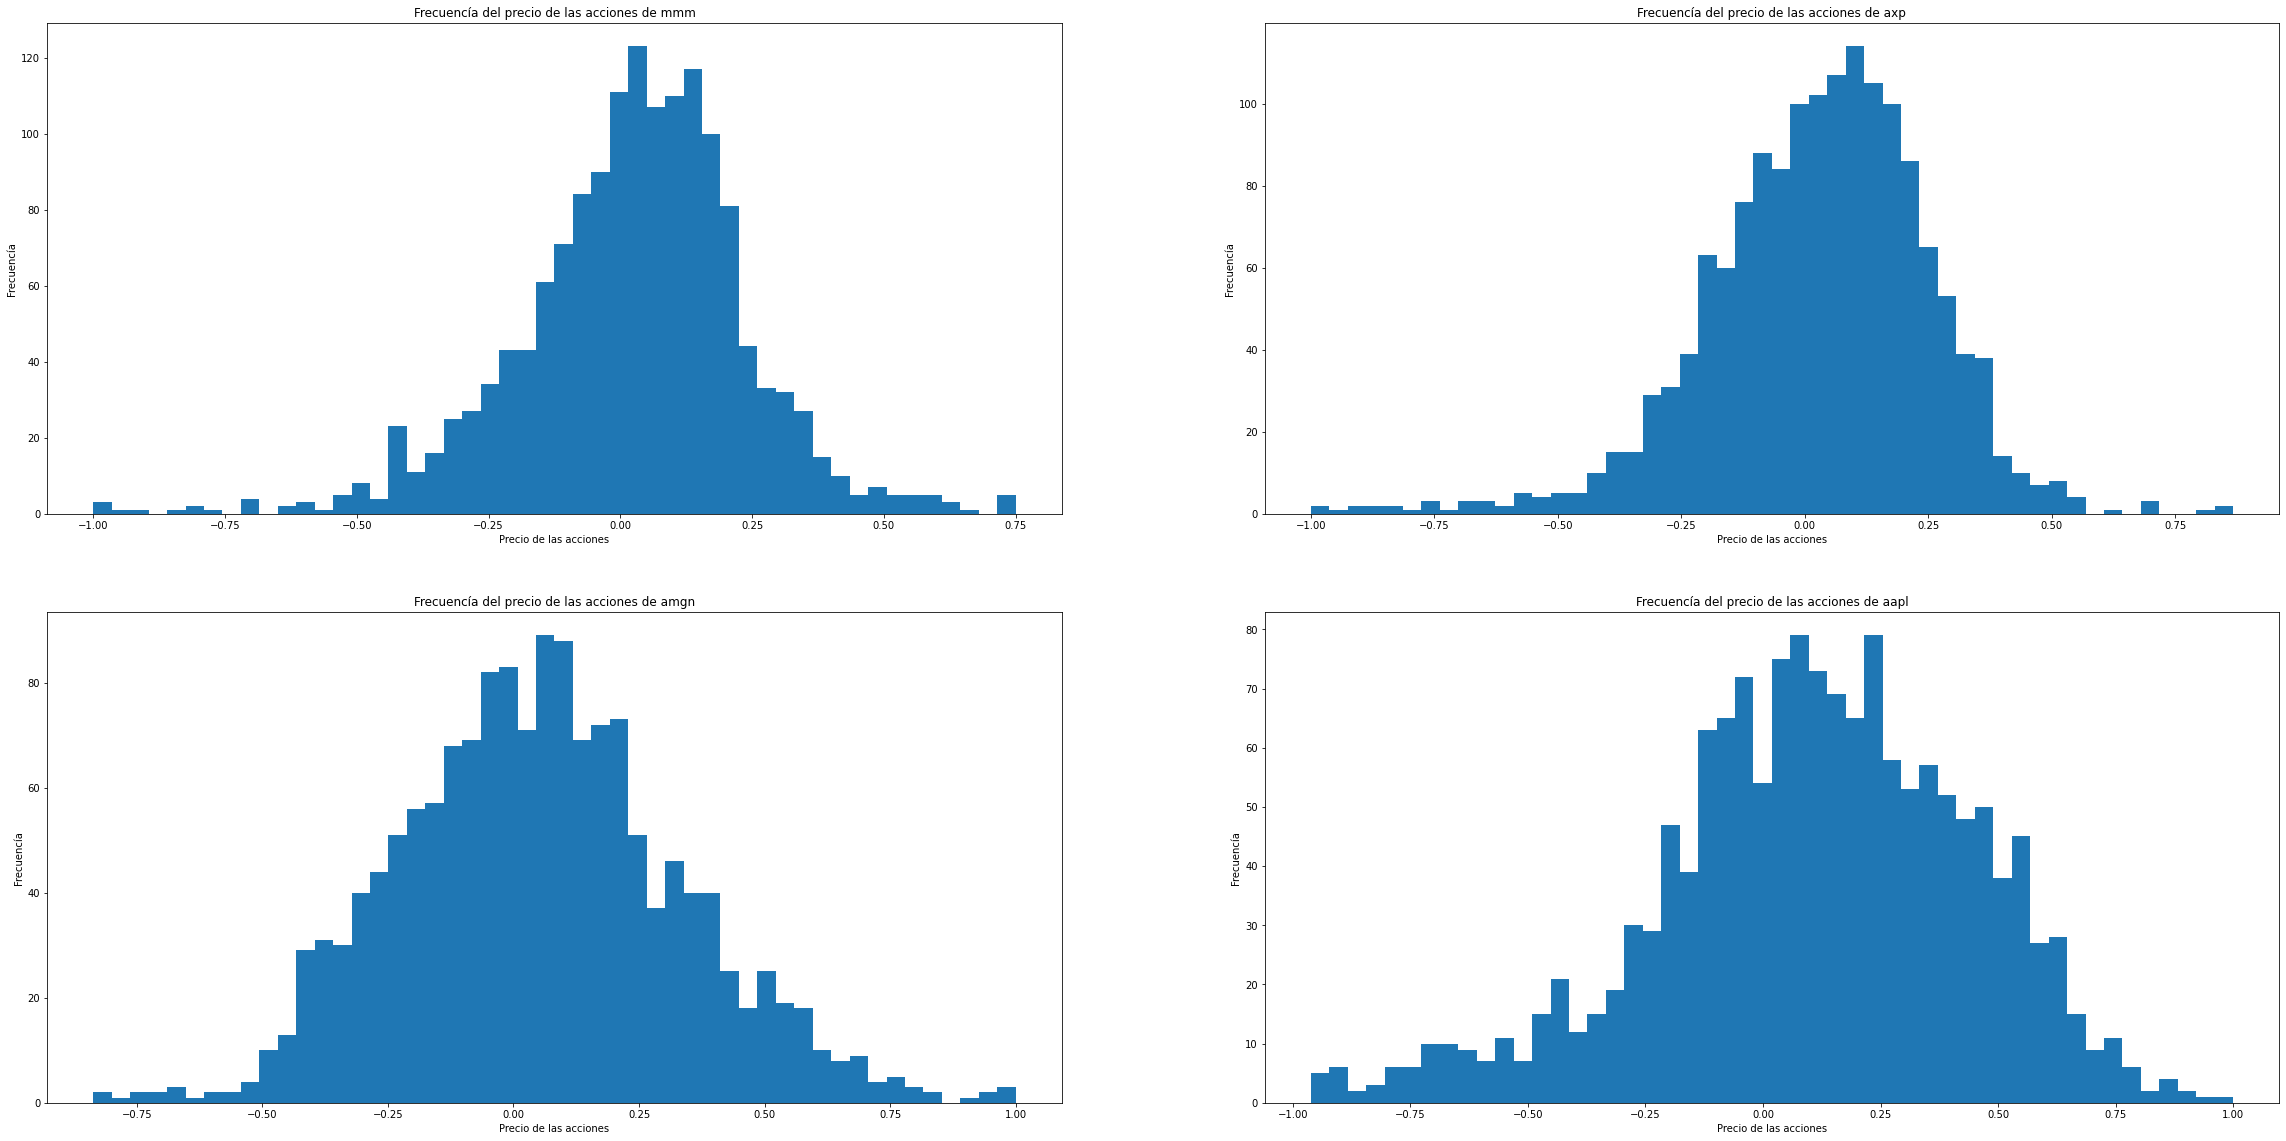

In [16]:
bars_stock('month_Y', names_list, dfs_list)

In [17]:
def get_reference_predicions(company, X_test):
    mean = stocks_data[company]['Rel_Close'].mean()
    #print(mean)
    all_prediction = []
    for item in X_test:
        #current_value = item[-1]
        #prediction = current_value + mean
        all_prediction.append(mean)
    return all_prediction

In [18]:
class Data_manager(object):
    # 84
    def __init__(self, company_name, vector_size = 84, training_percentage = 0.8):
        self.company_name = company_name
        self.vector_size = vector_size
        self.training_percentage = training_percentage
# IMPORTANT REMOVE NAN Y!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    def __get_company_data(self, y_column):
        filter_data = stocks_data[self.company_name]
        dataset = filter_data.values
        X_data = []
        y_data = []
        for i in range(self.vector_size, len(dataset)+1):

            #last_days_data = dataset[i-self.vector_size:i, 1:6]
            last_days_data = dataset[i-self.vector_size:i, 5:6]
            y = filter_data[y_column].values[i-1]
            if math.isnan(y):
                continue
            X_data.append(last_days_data)#.flatten())
            y_data.append(y)
        X_data, y_data = np.asarray(X_data).astype(np.float32), np.asarray(y_data).astype(np.float32)

        return X_data, y_data

    def __split_data(self, data):
        spliting_point = int(len(data) * self.training_percentage)
        return data[:spliting_point], data[spliting_point:]

    def get_processed_data(self, y_column = 'One_day_Y'):
        X_data, y_data = self.__get_company_data(y_column)
        
        X_train, X_test = self.__split_data(X_data)
        y_train, y_test = self.__split_data(y_data)

        X_train, y_train = shuffle(X_train, y_train)
        #print(f'Dataset shape: {X_data.shape}')
        #print(f'Shape of train data: {X_train.shape}')
        #print(f'Shape of test data: {X_test.shape}')
        return X_train, y_train, X_test, y_test

    
data_manager = Data_manager('aapl')
X_train, y_train, X_test, y_test = data_manager.get_processed_data()


In [19]:
data_manager = Data_manager('mmm')
X_train, y_train, X_test, y_test = data_manager.get_processed_data('One_day_Y')

display(stocks_data['mmm'][:85])
display(X_train[0])
display(y_train[0])

,Date,Open,High,Low,Volume,Rel_Close,One_day_Y,month_Y,6_months_Y,year_Y
21,2014-01-02 00:00:00+00:00,138.050003,139.000000,137.610001,3052100,-1.511583,0.017896,-0.424157,0.162356,0.405732
22,2014-01-03 00:00:00+00:00,138.369995,138.880005,138.029999,2133300,0.231660,-0.045752,-0.348830,0.143736,0.342038
23,2014-01-06 00:00:00+00:00,138.750000,139.289993,137.479996,2712100,-0.592266,0.001122,-0.307232,0.155112,0.330099
24,2014-01-07 00:00:00+00:00,137.449997,138.199997,137.130005,2525500,0.014524,-0.057242,-0.261723,0.157327,0.347795
25,2014-01-08 00:00:00+00:00,137.479996,137.750000,136.339996,3122700,-0.741002,-0.010178,-0.189847,0.163687,0.427113
...,...,...,...,...,...,...,...,...,...,...
101,2014-04-29 00:00:00+00:00,137.869995,137.899994,136.559998,1820900,0.233190,0.086488,0.144875,0.268972,0.305150
102,2014-04-30 00:00:00+00:00,137.630005,139.199997,137.330002,2904000,1.119588,0.095528,0.102421,0.265108,0.268828
103,2014-05-01 00:00:00+00:00,139.500000,141.490005,139.119995,3997400,1.236611,-0.037854,0.044153,0.223147,0.258944
104,2014-05-02 00:00:00+00:00,141.630005,141.830002,139.869995,5758500,-0.490024,0.027015,0.081393,0.263379,0.291532


array([[ 0.21255703],
       [-0.0070765 ],
       [ 0.6787853 ],
       [ 0.11237025],
       [-0.16134408],
       [ 0.40050027],
       [-0.4409014 ],
       [ 1.019269  ],
       [ 0.647131  ],
       [ 0.47013828],
       [-0.2408519 ],
       [-0.38628474],
       [-0.92791146],
       [ 0.20269378],
       [-0.0278976 ],
       [ 0.25816005],
       [ 0.44540328],
       [ 0.11085914],
       [ 0.4636992 ],
       [-0.73712313],
       [-0.69401073],
       [ 0.3913607 ],
       [ 0.05569231],
       [-0.02782579],
       [-0.3131721 ],
       [ 0.92152536],
       [ 0.463474  ],
       [ 0.12394685],
       [-0.3438553 ],
       [-0.24153335],
       [ 0.08300706],
       [-0.5460285 ],
       [ 0.29188895],
       [ 0.47813874],
       [ 0.04137793],
       [ 0.7652006 ],
       [-1.7992783 ],
       [ 0.8987105 ],
       [-0.36594558],
       [ 0.568255  ],
       [-0.30319875],
       [ 0.31103954],
       [-0.00689726],
       [ 0.28252757],
       [-1.0375834 ],
       [-0

0.027289668

In [24]:
class Model_manager(object):
    def __init__(self, input_shape):
        self.input_shape = input_shape
        self.model = self._get_model()
        self.callbacks = [EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=0)]
    def _get_model(self):
        pass
     
    def train_model(self, data_manager, y_column, verbose=0):
        self.X_train, self.y_train, self.X_test, self.y_test = data_manager.get_processed_data(y_column)
        #print(self.y_train)
        #print(self.X_train[0])
        #print(self.y_train[0])
        #print(self.X_test[0])
        #print(self.y_test[0])
        self.model.fit(self.X_train, self.y_train, 
                  batch_size=10,
                  epochs=30,
                  #epochs=1,
                  callbacks=self.callbacks,
                  validation_data=(self.X_test, self.y_test),
                  verbose=verbose)
    
    def predict(self, X_test):
        return self.model.predict(X_test)  

class CNN_model(Model_manager):
    def _get_model(self):
        model = Sequential()
        model.add(Input(shape=self.input_shape, name="prices"))
        model.add(BatchNormalization())
        model.add(Conv1D(64, 5, activation='relu', input_shape=self.input_shape))
        model.add(AveragePooling1D(3))
        model.add(Dropout(0.4))
        model.add(Conv1D(64, 3, activation='relu'))
        model.add(AveragePooling1D(3))
        model.add(Dropout(0.4))
        model.add(Flatten())
        model.add(Dropout(0.4))
        model.add(Dense(50))
        model.add(Dropout(0.4))
        model.add(Dense(1, activation='tanh'))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
        #model.summary()
        return model
 
    def __str__():
        return 'CNN'


class LSTM_model(Model_manager):
   
    def _get_model(self):
        hidden_nodes = int(2* self.input_shape[0] * self.input_shape[1])
        model = Sequential()
        #model.add(BatchNormalization())
        model.add(LSTM(hidden_nodes, return_sequences=False, recurrent_dropout=0.1, input_shape=self.input_shape))
        model.add(BatchNormalization())
        #model.add(Dense(50))
        #model.add(Dense(1))
        model.add(Dense(1, activation='tanh'))
        model.compile(optimizer='adam', loss='mean_squared_error')
        #model.summary()
        return model


    def __str__():
        return 'LSTM'



class CNN_LSTM_model(Model_manager):
    def _get_model(self):
        hidden_nodes = int(2* self.input_shape[0] * self.input_shape[1])
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Conv1D(32, 3, activation='relu', input_shape=self.input_shape))
        model.add(AveragePooling1D(3))     
        model.add(LSTM(hidden_nodes, return_sequences=False,))# recurrent_dropout=0.1))
        model.add(Dense(50))
        model.add(Dense(1, activation='tanh'))
        model.compile(optimizer='adam', loss='mean_squared_error')
        return model 

    def __str__():
        return 'CNN-LSTM'

In [21]:
def get_reference_rmse_off_comanpies_data(companies, y_column, normalization_values):
    predictions_errors = {}
    for company in companies.keys():
        print(f'Company: {company}')
        data_manager = Data_manager(company)
        X_train, y_train, X_test, y_test = data_manager.get_processed_data(y_column)
        ref_predictions = get_reference_predicions(company, X_test)
        rmse = np.sqrt(np.mean(((ref_predictions - y_test) ** 2)))
        #print(normalization_values[company][y_column])
        #print(ref_predictions)
        #print(y_test)
        print(f'Reference prediction RMSE: {rmse}')
        predictions_errors[company] = rmse * normalization_values[company][y_column]
        print(f'Denormalized reference prediction RMSE: {predictions_errors[company]}')
    return predictions_errors

def get_rmse_off_comanpies_data(companies, model_class, y_column, normalization_values):
    predictions_errors = {}
    for company in companies.keys():
        print(datetime.now().strftime("%H:%M:%S"))
        print(f'Company: {company}')
        data_manager = Data_manager(company)
        X_train, y_train, X_test, y_test = data_manager.get_processed_data(y_column)
        input_shape = (X_train.shape[1], X_train.shape[2])
        #print(X_train.shape)
        model_manager = model_class(input_shape)
        model_manager.train_model(data_manager, y_column, 1)
        predictions = model_manager.predict(X_test)
        rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
        #print(normalization_values[company][y_column])
        #print(predictions[0:20])
        #print(y_test)
        print(f'{model_manager.__class__.__name__} prediction RMSE: {rmse}')
        predictions_errors[company] = rmse * normalization_values[company][y_column]
        print(f'Denormalized {model_manager.__class__.__name__} prediction RMSE: {predictions_errors[company]}')
        
        #ref_predictions = get_reference_predicions(company, X_test)
        #ref_rmse = np.sqrt(np.mean(((ref_predictions - y_test) ** 2)))
        #print(f'Reference prediction RMSE: {ref_rmse}')
    return predictions_errors

In [25]:
companies_data = dict(list(stocks_data.items())[:5])
all_models = [CNN_LSTM_model]#, LSTM_model_manager]
y_columns = ['One_day_Y']

#companies_data = stocks_data
#all_models = [CNN_model_manager, LSTM_model_manager, LSTM_CNN_model_manager]
#y_columns = ['One_day_Y', 'month_Y', '6_months_Y', 'year_Y']

#companies_data = dict(list(stocks_data.items())[:5])
#companies_data = {'aapl': stocks_data['aapl']}

#reference_errors = get_reference_rmse_off_comanpies_data(companies_data)
print(f'Models to test: {all_models}')

rmse = {}
for y_column in y_columns:
    print(f'Getting data for {y_column}')
    rmse[y_column] = {}
    rmse[y_column]['reference'] = get_reference_rmse_off_comanpies_data(companies_data, y_column, normalization_values)

    for model_class in all_models:
        print(f'Model: {model_class.__name__}')
        rmse[y_column][model_class.__name__] = get_rmse_off_comanpies_data(companies_data, model_class, y_column, normalization_values)

for y_column in y_columns:
    for key, value in rmse[y_column].items():
        print(f'{y_column} - {key}: {value}')
        print(f'Average: {sum(value.values())/len(value)}')


Models to test: [<class '__main__.CNN_LSTM_model'>]
Getting data for One_day_Y
Company: mmm
Reference prediction RMSE: 0.12747046326890665
Denormalized reference prediction RMSE: 1.6501106594734545
Company: axp
Reference prediction RMSE: 0.10540529322394668
Denormalized reference prediction RMSE: 1.275497963891936
Company: amgn
Reference prediction RMSE: 0.15371071788079924
Denormalized reference prediction RMSE: 1.4732577673335665
Company: aapl
Reference prediction RMSE: 0.20093116313942389
Denormalized reference prediction RMSE: 2.0014224876256836
Company: ba
Reference prediction RMSE: 0.20900100553920242
Denormalized reference prediction RMSE: 2.0648257891932627
Model: CNN_LSTM_model
19:17:01
Company: mmm
Epoch 1/30
115/115 [==============================] - 3s 9ms/step - loss: 0.0094 - val_loss: 0.0159
Epoch 2/30
115/115 [==============================] - 1s 5ms/step - loss: 0.0069 - val_loss: 0.0165
Epoch 3/30
115/115 [==============================] - 1s 5ms/step - loss: 0.0075 -

# Resultados solo con precio vector size 30
reference_errors: {'mmm': 0.12639669712670604, 'axp': 0.10516081298815168, 'amgn': 0.15513531236337955, 'aapl': 0.20628521927902696, 'ba': 0.2119133666179077, 'cat': 0.20520064658176462, 'cvx': 0.20644012051736552, 'csco': 0.1816987143816782, 'ko': 0.13072762644142363, 'gs': 0.1729219438945541, 'hd': 0.20998526974073523, 'hon': 0.15965695309234965, 'ibm': 0.1611092088361266, 'intc': 0.18122322912364042, 'jnj': 0.12708295937512648, 'jpm': 0.16061758756373987, 'mcd': 0.13157768512306356, 'mrk': 0.12081787701196396, 'msft': 0.16796828706401573, 'nke': 0.14118812211336132, 'pg': 0.12493433700754471, 'crm': 0.17492578176245271, 'trv': 0.1400982030868789, 'unh': 0.21978116826720034, 'vz': 0.14416770813308818, 'v': 0.1539725269124731, 'wba': 0.12194538094954756, 'wmt': 0.09930090844283324, 'dis': 0.1319652957943606}

Average: 0.15773099826180903

CNN_model_manager: {'mmm': 0.12677968, 'axp': 0.104291864, 'amgn': 0.14738268, 'aapl': 0.18780582, 'ba': 0.20323151, 'cat': 0.20321868, 'cvx': 0.20694418, 'csco': 0.17380753, 'ko': 0.13045846, 'gs': 0.1717221, 'hd': 0.20143902, 'hon': 0.15452726, 'ibm': 0.16091743, 'intc': 0.17460047, 'jnj': 0.12405487, 'jpm': 0.15201281, 'mcd': 0.12613735, 'mrk': 0.11576171, 'msft': 0.14174306, 'nke': 0.12921782, 'pg': 0.12495897, 'crm': 0.15425636, 'trv': 0.13860482, 'unh': 0.19998154, 'vz': 0.1436676, 'v': 0.1326786, 'wba': 0.121388696, 'wmt': 0.0965106, 'dis': 0.12655099}

Average: 0.15085008509200196

LSTM_model_manager: {'mmm': 0.12710693, 'axp': 0.102945186, 'amgn': 0.1473678, 'aapl': 0.18844834, 'ba': 0.20263742, 'cat': 0.20372827, 'cvx': 0.20698647, 'csco': 0.1734679, 'ko': 0.1302492, 'gs': 0.17224196, 'hd': 0.20163742, 'hon': 0.15445337, 'ibm': 0.1615237, 'intc': 0.17312668, 'jnj': 0.12419962, 'jpm': 0.15210448, 'mcd': 0.12376496, 'mrk': 0.11500037, 'msft': 0.14072827, 'nke': 0.12827896, 'pg': 0.12376553, 'crm': 0.1552415, 'trv': 0.13848446, 'unh': 0.19942139, 'vz': 0.14355598, 'v': 0.13432041, 'wba': 0.12604406, 'wmt': 0.09558913, 'dis': 0.12591994}

Average: 0.15077033536187534

LSTM_CNN_model_manager: {'mmm': 0.12510285, 'axp': 0.10406879, 'amgn': 0.14692953, 'aapl': 0.18849054, 'ba': 0.20238164, 'cat': 0.2028239, 'cvx': 0.20702624, 'csco': 0.17289925, 'ko': 0.13003711, 'gs': 0.17270643, 'hd': 0.20176373, 'hon': 0.15427361, 'ibm': 0.16120166, 'intc': 0.17333151, 'jnj': 0.122907445, 'jpm': 0.15159696, 'mcd': 0.12338512, 'mrk': 0.115069225, 'msft': 0.1413833, 'nke': 0.12837064, 'pg': 0.12430071, 'crm': 0.15404445, 'trv': 0.13764413, 'unh': 0.19990213, 'vz': 0.14404447, 'v': 0.13307115, 'wba': 0.12152277, 'wmt': 0.09566803, 'dis': 0.12712577}

Average: 0.15045079743040018


# Resultados solo con precio vector size 60
reference_errors: {'mmm': 0.12735986547926992, 'axp': 0.10527543886973217, 'amgn': 0.1545013467947001, 'aapl': 0.2019894903737092, 'ba': 0.20761941775941753, 'cat': 0.20493311885251012, 'cvx': 0.2045603353373171, 'csco': 0.18155231957565374, 'ko': 0.13041945548674555, 'gs': 0.1732991253592863, 'hd': 0.20702381501309525, 'hon': 0.160415256634335, 'ibm': 0.1584407817540628, 'intc': 0.17899021938005374, 'jnj': 0.12745045611485545, 'jpm': 0.16072214140279362, 'mcd': 0.13013935378284724, 'mrk': 0.12106538723232818, 'msft': 0.1667854083156966, 'nke': 0.14144897321437405, 'pg': 0.12544259537551342, 'crm': 0.1730807503003789, 'trv': 0.14005034143019165, 'unh': 0.22046949871495314, 'vz': 0.14102821766008353, 'v': 0.151599499520816, 'wba': 0.12264840999165305, 'wmt': 0.09858417499885187, 'dis': 0.13275511482430075}

Average: 0.15688449343274224

CNN_model_manager: {'mmm': 0.12730043, 'axp': 0.104832545, 'amgn': 0.14766507, 'aapl': 0.1856709, 'ba': 0.19790745, 'cat': 0.20489065, 'cvx': 0.2067554, 'csco': 0.17673118, 'ko': 0.13023147, 'gs': 0.173412, 'hd': 0.19899246, 'hon': 0.15529473, 'ibm': 0.1592725, 'intc': 0.16987507, 'jnj': 0.12692131, 'jpm': 0.15342101, 'mcd': 0.12254357, 'mrk': 0.115140215, 'msft': 0.14095104, 'nke': 0.12786984, 'pg': 0.12436841, 'crm': 0.15484263, 'trv': 0.13770968, 'unh': 0.20123446, 'vz': 0.14059421, 'v': 0.13170035, 'wba': 0.12351029, 'wmt': 0.095595755, 'dis': 0.12713724}

Average: 0.15042661669953117

LSTM_model_manager: {'mmm': 0.12730765, 'axp': 0.103654675, 'amgn': 0.14698015, 'aapl': 0.18651752, 'ba': 0.19726716, 'cat': 0.2025604, 'cvx': 0.20501631, 'csco': 0.17364872, 'ko': 0.13098691, 'gs': 0.17262456, 'hd': 0.19837895, 'hon': 0.15510076, 'ibm': 0.15767872, 'intc': 0.1701297, 'jnj': 0.123242095, 'jpm': 0.1520005, 'mcd': 0.12232813, 'mrk': 0.115002885, 'msft': 0.14159444, 'nke': 0.12684028, 'pg': 0.12443968, 'crm': 0.15388559, 'trv': 0.13776906, 'unh': 0.20058031, 'vz': 0.14072497, 'v': 0.13015996, 'wba': 0.123301506, 'wmt': 0.09556595, 'dis': 0.12664875}

Average: 0.1497219418143404

LSTM_CNN_model_manager: {'mmm': 0.12726033, 'axp': 0.10331156, 'amgn': 0.14775342, 'aapl': 0.18441579, 'ba': 0.19564362, 'cat': 0.202139, 'cvx': 0.20496263, 'csco': 0.17481792, 'ko': 0.13037619, 'gs': 0.1729647, 'hd': 0.19844925, 'hon': 0.1547156, 'ibm': 0.15756047, 'intc': 0.16951491, 'jnj': 0.12346163, 'jpm': 0.15137589, 'mcd': 0.12162107, 'mrk': 0.11489429, 'msft': 0.13999152, 'nke': 0.1265488, 'pg': 0.12433817, 'crm': 0.15293165, 'trv': 0.13772741, 'unh': 0.2018198, 'vz': 0.14066178, 'v': 0.13027006, 'wba': 0.12332748, 'wmt': 0.09447095, 'dis': 0.12634957}

Average: 0.1494370847940445

# Resultados solo con precio vector size 120
reference_errors: {'mmm': 0.12652576963103687, 'axp': 0.10513841824204652, 'amgn': 0.15525369745404413, 'aapl': 0.1932187140476691, 'ba': 0.20596519737521687, 'cat': 0.20064806438683197, 'cvx': 0.2010267295356418, 'csco': 0.17673964930725036, 'ko': 0.1314224731463911, 'gs': 0.16528440116579338, 'hd': 0.20201539847279895, 'hon': 0.16096058440351377, 'ibm': 0.15628600099319884, 'intc': 0.17857906801018658, 'jnj': 0.12932470079709385, 'jpm': 0.1594559150451923, 'mcd': 0.1299428165001549, 'mrk': 0.12144258816876585, 'msft': 0.16255047905739936, 'nke': 0.14029585647605308, 'pg': 0.12697531267783868, 'crm': 0.16405351294708137, 'trv': 0.13569668332434437, 'unh': 0.21978563411633512, 'vz': 0.14192274193593182, 'v': 0.14846356974360853, 'wba': 0.12431063503649803, 'wmt': 0.09575854123938717, 'dis': 0.13316568346655472}

Average: 0.15490375298978828

CNN_model_manager: {'mmm': 0.13236243, 'axp': 0.10364446, 'amgn': 0.14706069, 'aapl': 0.1790026, 'ba': 0.1989098, 'cat': 0.19853349, 'cvx': 0.20210457, 'csco': 0.1690873, 'ko': 0.13251108, 'gs': 0.16624351, 'hd': 0.19484432, 'hon': 0.15756533, 'ibm': 0.15752284, 'intc': 0.16937986, 'jnj': 0.13049778, 'jpm': 0.1506973, 'mcd': 0.12177958, 'mrk': 0.115953185, 'msft': 0.13627662, 'nke': 0.12685256, 'pg': 0.12615117, 'crm': 0.14406939, 'trv': 0.13283512, 'unh': 0.201459, 'vz': 0.14272393, 'v': 0.12957735, 'wba': 0.13130458, 'wmt': 0.09540055, 'dis': 0.12801996}

Average: 0.1490472542314694

LSTM_model_manager: {'mmm': 0.12708145, 'axp': 0.10348081, 'amgn': 0.14832018, 'aapl': 0.17828354, 'ba': 0.19696237, 'cat': 0.19836089, 'cvx': 0.20115943, 'csco': 0.17156778, 'ko': 0.13179901, 'gs': 0.16492422, 'hd': 0.19590153, 'hon': 0.15676484, 'ibm': 0.15626478, 'intc': 0.17113659, 'jnj': 0.12664889, 'jpm': 0.15054795, 'mcd': 0.12258099, 'mrk': 0.11513223, 'msft': 0.13590015, 'nke': 0.1262888, 'pg': 0.12627181, 'crm': 0.14410552, 'trv': 0.13302028, 'unh': 0.20074749, 'vz': 0.14141247, 'v': 0.12893784, 'wba': 0.1317629, 'wmt': 0.09273336, 'dis': 0.12769012}

Average: 0.14847545685439273

LSTM_CNN_model_manager: {'mmm': 0.12645797, 'axp': 0.104201205, 'amgn': 0.14746223, 'aapl': 0.17821737, 'ba': 0.19606848, 'cat': 0.19826974, 'cvx': 0.20221928, 'csco': 0.1700017, 'ko': 0.13150924, 'gs': 0.16470613, 'hd': 0.19479804, 'hon': 0.15580691, 'ibm': 0.156094, 'intc': 0.1692909, 'jnj': 0.12778744, 'jpm': 0.15043978, 'mcd': 0.12087661, 'mrk': 0.11611441, 'msft': 0.13606203, 'nke': 0.12683906, 'pg': 0.12597692, 'crm': 0.1444094, 'trv': 0.13377617, 'unh': 0.20064175, 'vz': 0.14188294, 'v': 0.12787852, 'wba': 0.12540938, 'wmt': 0.09277821, 'dis': 0.12773447}

Average: 0.14805897556502243


# Resultados solo con mas valores vector size y 30 días

LSTM_CNN_model_manager prediction RMSE: 0.1300026923418045

reference_errors: {'mmm': 0.12639669712670604, 'axp': 0.10516081298815168, 'amgn': 0.15513531236337955, 'aapl': 0.20628521927902696, 'ba': 0.2119133666179077, 'cat': 0.20520064658176462, 'cvx': 0.20644012051736552, 'csco': 0.1816987143816782, 'ko': 0.13072762644142363, 'gs': 0.1729219438945541, 'hd': 0.20998526974073523, 'hon': 0.15965695309234965, 'ibm': 0.1611092088361266, 'intc': 0.18122322912364042, 'jnj': 0.12708295937512648, 'jpm': 0.16061758756373987, 'mcd': 0.13157768512306356, 'mrk': 0.12081787701196396, 'msft': 0.16796828706401573, 'nke': 0.14118812211336132, 'pg': 0.12493433700754471, 'crm': 0.17492578176245271, 'trv': 0.1400982030868789, 'unh': 0.21978116826720034, 'vz': 0.14416770813308818, 'v': 0.1539725269124731, 'wba': 0.12194538094954756, 'wmt': 0.09930090844283324, 'dis': 0.1319652957943606}

Average: 0.15773099826180903

CNN_model_manager: {'mmm': 0.3108143, 'axp': 0.10297263, 'amgn': 0.24987012, 'aapl': 0.309005, 'ba': 0.5158484, 'cat': 0.3486827, 'cvx': 0.3463991, 'csco': 0.32817107, 'ko': 0.3285044, 'gs': 0.5088702, 'hd': 0.38702813, 'hon': 0.20972838, 'ibm': 0.59728754, 'intc': 0.17218083, 'jnj': 0.36517608, 'jpm': 0.15157281, 'mcd': 0.3097658, 'mrk': 0.2712999, 'msft': 0.14033718, 'nke': 0.39627022, 'pg': 0.1899222, 'crm': 0.58880615, 'trv': 0.13758418, 'unh': 0.5591037, 'vz': 0.14373823, 'v': 0.1326311, 'wba': 0.4767764, 'wmt': 0.4102639, 'dis': 0.421312}

Average: 0.3244800901618497

LSTM_model_manager: {'mmm': 0.12623419, 'axp': 0.10330476, 'amgn': 0.14660394, 'aapl': 0.18750788, 'ba': 0.20006919, 'cat': 0.2023193, 'cvx': 0.20644663, 'csco': 0.17318566, 'ko': 0.12976734, 'gs': 0.17131868, 'hd': 0.20133178, 'hon': 0.15465282, 'ibm': 0.16062373, 'intc': 0.17259037, 'jnj': 0.1226197, 'jpm': 0.15162246, 'mcd': 0.12315995, 'mrk': 0.11491603, 'msft': 0.1404346, 'nke': 0.12628493, 'pg': 0.12356287, 'crm': 0.15351824, 'trv': 0.13748157, 'unh': 0.19960417, 'vz': 0.14331634, 'v': 0.13264883, 'wba': 0.1287289, 'wmt': 0.09535904, 'dis': 0.12544154}

Average: 0.1501605323162572

LSTM_CNN_model_manager: {'mmm': 0.1360734, 'axp': 0.12095024, 'amgn': 0.16743289, 'aapl': 0.19073327, 'ba': 0.22425656, 'cat': 0.21557474, 'cvx': 0.21057607, 'csco': 0.17978059, 'ko': 0.15921086, 'gs': 0.17419831, 'hd': 0.20776913, 'hon': 0.15585609, 'ibm': 0.16343443, 'intc': 0.17444092, 'jnj': 0.14478369, 'jpm': 0.15493745, 'mcd': 0.12706108, 'mrk': 0.1237657, 'msft': 0.15773813, 'nke': 0.13030465, 'pg': 0.13226128, 'crm': 0.16190657, 'trv': 0.15055919, 'unh': 0.21507709, 'vz': 0.15125029, 'v': 0.14105566, 'wba': 0.13971852, 'wmt': 0.10050108, 'dis': 0.13000269}

Average: 0.16004174331138873

In [ ]:
results = {
    'One_day_Y': {
        'LSTM_CNN_model_manager': {'mmm': 1.6268720745287761, 'axp': 1.2444442569197864, 'amgn': 1.3889069362709454, 'aapl': 1.8272078499613487, 'ba': 1.9431947048352618, 'cat': 1.8164517868472552, 'cvx': 1.2861101681167242, 'csco': 1.6592428266922652, 'ko': 1.1005321109991735, 'gs': 1.6414322508521264, 'hd': 1.2679870397720507, 'hon': 1.1735833686112815, 'ibm': 1.3779056390493365, 'intc': 1.7854651560160824, 'jnj': 1.2437601521125508, 'jpm': 1.2649894643911481, 'mcd': 0.9876970076860873, 'mrk': 1.2036324951633488, 'msft': 1.454732104285065, 'nke': 1.5420391408253613, 'pg': 1.0966004456847427, 'crm': 1.949259119875684, 'trv': 1.13753633893751, 'unh': 1.6300950186412841, 'vz': 1.0816917285333187, 'v': 1.3355989403853643, 'wba': 1.748865846433651, 'wmt': 1.0308659082854612, 'dis': 1.4712394962418178},
    },
    'month_Y': {
        'LSTM_CNN_model_manager': {'mmm': 7.626423937354859, 'axp': 5.334653697564553, 'amgn': 7.185027244860628, 'aapl': 8.776494189694239, 'ba': 9.33642413722438, 'cat': 9.065166600579168, 'cvx': 4.756984849487136, 'csco': 8.202444473059506, 'ko': 3.7397745197679897, 'gs': 7.950113119040864, 'hd': 5.720552350642004, 'hon': 5.736260722783757, 'ibm': 6.929628652867262, 'intc': 8.473565839862742, 'jnj': 5.107601185486164, 'jpm': 6.121077348598631, 'mcd': 4.175631175874687, 'mrk': 4.563470740618389, 'msft': 4.549085770596125, 'nke': 5.8949133628328605, 'pg': 3.359552719573058, 'crm': 6.870548170902156, 'trv': 5.329762267197013, 'unh': 7.821708739881777, 'vz': 4.002948817297936, 'v': 4.116546541787264, 'wba': 8.841252428800514, 'wmt': 4.420340291769749, 'dis': 7.268467518610254}
    },
    'six_months_Y': {
        'LSTM_CNN_model_manager': {'mmm': 13.507314728702031, 'axp': 19.605122335883287, 'amgn': 15.196791288343029, 'aapl': 27.925251026004073, 'ba': 29.69245036927118, 'cat': 16.611254504186345, 'cvx': 16.004062028205194, 'csco': 19.38732111812297, 'ko': 12.684276862904978, 'gs': 14.539164692270157, 'hd': 13.26043920487676, 'hon': 17.683671841808966, 'ibm': 13.477504312858018, 'intc': 17.855461923545757, 'jnj': 8.291341529693211, 'jpm': 19.31551994726866, 'mcd': 15.273230178963267, 'mrk': 8.927682168590012, 'msft': 12.808668111750016, 'nke': 11.886468046542191, 'pg': 11.981161040911346, 'crm': 13.323450787695558, 'trv': 19.75824182382945, 'unh': 12.66979331116484, 'vz': 7.160469102671066, 'v': 11.63934091499839, 'wba': 20.826838691028698, 'wmt': 9.508127595717669, 'dis': 19.216072399649143}
    },
    'year_Y': {
        'LSTM_CNN_model_manager': {'mmm': 15.757462200509059, 'axp': 24.848313815454354, 'amgn': 16.39553706829035, 'aapl': 66.91839683992188, 'ba': 52.488087833901226, 'cat': 27.522016393713287, 'cvx': 25.98424951565799, 'csco': 30.87724083767202, 'ko': 13.380875511077592, 'gs': 20.061835242863093, 'hd': 13.632084633275925, 'hon': 20.377568149979233, 'ibm': 17.259668253734606, 'intc': 17.875811141419277, 'jnj': 9.861585893954048, 'jpm': 23.170658897181028, 'mcd': 15.686026089176005, 'mrk': 12.033376683205928, 'msft': 22.53205384582023, 'nke': 15.930852418142784, 'pg': 15.04175225041479, 'crm': 26.929195317166823, 'trv': 22.629196172729117, 'unh': 16.213700887748757, 'vz': 9.445782434798078, 'v': 14.928675011692736, 'wba': 17.46047798309229, 'wmt': 11.148002544524994, 'dis': 22.49561745135931}
    },
}


In [ ]:
data_to_show = results['One_day_Y']
labels = list(data_to_show.keys())[1:]
CNN_model_manager = data_to_show['CNN_model_manager'].values()
#len(CNN_model_manager)
reshaped_data = {}
for key in data_to_show['CNN_model_manager'].keys():
    reshaped_data[key] = []
    for algo in labels:
        reshaped_data[key].append(data_to_show[algo][key])
#reshaped_data
x = np.arange(len(labels))
x
x - width/2

In [ ]:
def draw_results(data, y_label, title):
    labels = data.keys()
    values = data.values()
    y_pos = np.arange(len(labels))
    plt.rcParams["figure.figsize"] = ((len(labels) * .5) + 3, 5)
    plt.bar(y_pos, values, align='center', alpha=0.5)
    plt.xticks(y_pos, labels)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

y_label = 'RMSE'
class_type_ref = {'CNN_model_manager': 'CNN', 'LSTM_model_manager': 'LSTM', 'LSTM_CNN_model_manager': 'LSTM-CNN'}


In [ ]:
period_result = results['One_day_Y']

#draw_results(period_result['CNN_model_manager'], y_label, 'Error para prediciones a un día usando CNN')
#draw_results(period_result['LSTM_model_manager'], y_label, 'Error para prediciones a un día usando LSTM')
draw_results(period_result['LSTM_CNN_model_manager'], y_label, 'Error para prediciones a un día usando LSTM-CNN')

averages = {}
for algo in list(period_result.keys())[1:]:
    averages[class_type_ref[algo]] = statistics.mean(period_result[algo].values())

#draw_results(averages, y_label, 'Media del error cometido por cada algoritmo para prediciones a un día')

In [ ]:
period_result = results['month_Y']

#draw_results(period_result['CNN_model_manager'], y_label, 'Error para prediciones a un mes usando CNN')
#draw_results(period_result['LSTM_model_manager'], y_label, 'Error para prediciones a un mes usando LSTM')
draw_results(period_result['LSTM_CNN_model_manager'], y_label, 'Error para prediciones a un mes usando LSTM-CNN')

averages = {}
for algo in list(period_result.keys())[1:]:
    averages[class_type_ref[algo]] = statistics.mean(period_result[algo].values())

draw_results(averages, y_label, 'Media del error cometido por cada algoritmo para prediciones a un mes')

In [ ]:
period_result = results['six_months_Y']

#draw_results(period_result['CNN_model_manager'], y_label, 'Error para prediciones a 6 meses usando CNN')
#draw_results(period_result['LSTM_model_manager'], y_label, 'Error para prediciones a 6 meses usando LSTM')
draw_results(period_result['LSTM_CNN_model_manager'], y_label, 'Error para prediciones a 6 meses usando LSTM-CNN')

averages = {}
for algo in list(period_result.keys())[1:]:
    averages[class_type_ref[algo]] = statistics.mean(period_result[algo].values())

draw_results(averages, y_label, 'Media del error cometido por cada algoritmo para prediciones a 6 meses')

In [ ]:
period_result = results['year_Y']

#draw_results(period_result['CNN_model_manager'], y_label, 'Error para prediciones a un año usando CNN')
#draw_results(period_result['LSTM_model_manager'], y_label, 'Error para prediciones a un año usando LSTM')
draw_results(period_result['LSTM_CNN_model_manager'], y_label, 'Error para prediciones a un año usando LSTM-CNN')

averages = {}
for algo in list(period_result.keys())[1:]:
    averages[class_type_ref[algo]] = statistics.mean(period_result[algo].values())

draw_results(averages, y_label, 'Media del error cometido por cada algoritmo para prediciones a un año')